In [1]:
import matplotlib.pyplot as plt
from keras.models import load_model, Model
import numpy as np
from utils.visualizations import GradCAM, GuidedGradCAM, GBP, LRP, CLRP, SGLRP, SGLRP2
from utils.helper import heatmap
import innvestigate.utils as iutils
import os
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
import math
import scipy.io as sio
import tqdm
from utils.fileutils import CacheStorage

os.environ["CUDA_VISIBLE_DEVICES"]="2"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_shape = (40, 40, 1)
num_classes = 10

In [3]:
def load_images_from_mat(data_dir, include_transforms = False):
    mat_list = os.listdir(data_dir)
    images = np.empty((0, input_shape[0]*input_shape[1]*input_shape[2]))
    labels = np.empty((0,num_classes))
    transforms = np.empty((0,6))
    affines = np.empty((0, 6))
    for mat_path in tqdm.tqdm(mat_list):
        if mat_path.endswith('.mat'):
            mat_contents = sio.loadmat(os.path.join(data_dir, mat_path))
            data = mat_contents['affNISTdata'][0,0]
#             print(data.dtype)
            images = np.append(images, data['image'].T, axis=0)
            labels = np.append(labels, data['label_one_of_n'].T, axis=0)
            if (include_transforms):
                transforms = np.append(transforms, data['human_readable_transform'].T, axis=0)
                affines = np.append(affines, data['matrix_old_to_new'].T, axis=0)
    return images, labels, transforms, affines
x_test, y_test, t_test, a_test = load_images_from_mat(os.path.join('data', 'affMNIST','test'), True)

100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


In [4]:
def get_affnist_images(data_dir, dataset, include_transforms=False):
    imgs = []
    labels = []

    cache = CacheStorage()
    print("Try to load cache file")
    imgs = cache.get_cache(os.path.join('cache', "mnist_imgs_"+dataset))
    labels = cache.get_cache(os.path.join('cache', "mnist_labels_"+dataset))
    transforms = cache.get_cache(os.path.join('cache', "mnist_transforms_"+dataset))
    if imgs is None or labels is None or transforms is None:
        print("Making cache file")
        imgs, labels, transforms = load_images_from_mat(os.path.join(data_dir, dataset), include_transforms)
        cache.set_cache(os.path.join('cache', "mnist_imgs_"+dataset), imgs)
        cache.set_cache(os.path.join('cache', "mnist_labels_"+dataset), labels)
        cache.set_cache(os.path.join('cache', "mnist_transforms_"+dataset), transforms)
    return imgs, labels, transforms

In [5]:
# x_test, y_test, t_test = get_affnist_images(os.path.join('data', 'affMNIST'), 'test', True)
x_train, y_train, _ = get_affnist_images(os.path.join('data', 'affMNIST'), 'training', False)

Try to load cache file


In [6]:
print(np.shape(x_train))

(1920000, 1600)


In [7]:
#This will be your trained model instead.

from utils.models import VGG10_nodrop, preprocess_input
model = VGG10_nodrop(
    input_shape=input_shape,
    nb_class=num_classes
)
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
__________

In [8]:
#train
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping

nb_iterations = 50000
learning_rate=0.0001
batch_size=128
dataset_prefix="affmnist_nonorm"

save=True
train=True

if train:
    x_train = preprocess_input(x_train, input_shape[0], input_shape[1], input_shape[2], normalization="positive")
    nb_epochs = math.ceil(nb_iterations * (batch_size / x_train.shape[0]))
x_test = preprocess_input(x_test, input_shape[0], input_shape[1], input_shape[2], normalization="positive")

validation_split=0.0001

if not os.path.exists(os.path.join("logs", "%s" % (dataset_prefix))):
    os.mkdir(os.path.join("logs", "%s" % (dataset_prefix)))
model_checkpoint = ModelCheckpoint(os.path.join("weights", "%s_val_acc_weights.h5" % (dataset_prefix)), verbose=1, monitor='val_acc', save_best_only=True)
tensorboard = TensorBoard(log_dir=os.path.join("logs", "%s" % (dataset_prefix)), batch_size=batch_size)
csv_logger = CSVLogger(os.path.join('logs', '%s.csv' % (dataset_prefix)))

if not save:
    callback_list = []
else:
#     callback_list = [tensorboard, csv_logger]
    callback_list = [model_checkpoint, tensorboard, csv_logger]


optm = Adam(lr=learning_rate)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

if train:
    #train
    model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs, callbacks=callback_list, verbose=1, validation_split=validation_split)
    if save:
        model.save_weights(os.path.join("weights", "%s_val_loss_weights_final.h5" % (dataset_prefix)))
else: 
        model.load_weights(os.path.join("weights", "%s_val_loss_weights_final.h5" % (dataset_prefix)))

Train on 1919808 samples, validate on 192 samples
Epoch 1/4
1919808/1919808 [==============================] - 12680s 7ms/step - loss: 0.0582 - acc: 0.9817 - val_loss: 0.0103 - val_acc: 0.9948

Epoch 00001: val_acc improved from -inf to 0.99479, saving model to weights/affmnist_nonorm_val_acc_weights.h5
Epoch 2/4
1919808/1919808 [==============================] - 12537s 7ms/step - loss: 0.0140 - acc: 0.9957 - val_loss: 0.0259 - val_acc: 0.9896

Epoch 00002: val_acc did not improve from 0.99479
Epoch 3/4
1919808/1919808 [==============================] - 13311s 7ms/step - loss: 0.0088 - acc: 0.9973 - val_loss: 0.0087 - val_acc: 0.9948

Epoch 00003: val_acc did not improve from 0.99479
Epoch 4/4
1919808/1919808 [==============================] - 13335s 7ms/step - loss: 0.0065 - acc: 0.9980 - val_loss: 3.6689e-04 - val_acc: 1.0000

Epoch 00004: val_acc improved from 0.99479 to 1.00000, saving model to weights/affmnist_nonorm_val_acc_weights.h5


In [9]:
# Only the partial model is needed for the visualizers. Use innvestigate.utils.keras.graph.pre_softmax_tensors()
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
__________

In [10]:
# Range of input images
# keras_applications VGG16 weights assume a range of (-127.5, 127.5). Change this to a range suitable for your model.
max_input = -1.
min_input = 1.

In [11]:
# Change this to load a list of images you want. For this example, we are only loading one image, but you can load a list of files.
orig_imgs = x_test
input_imgs = np.copy(orig_imgs[:])

num_images = input_imgs.shape[0]
print(num_images)
half_num_images = int(num_images / 2)
assert(half_num_images == num_images / 2.)

shuffled_ids = np.arange(num_images)
import random
random.shuffle(shuffled_ids)
shuffled_imgs = input_imgs[shuffled_ids]
combined_images = np.maximum(shuffled_imgs[:half_num_images], shuffled_imgs[half_num_images:])
print(np.shape(input_imgs))


320000
(320000, 40, 40, 1)


In [29]:
# Select only one from your list for example
example_id = 3

In [13]:
shuffuled_t_test = t_test[shuffled_ids]
print(shuffuled_t_test[example_id])
shuffuled_y_test = y_test[shuffled_ids]

[ 5.59376482 -0.18365336  0.84202952  0.80801291 -8.         -8.        ]


In [14]:
shuffuled_a_test = a_test[shuffled_ids]
affine = np.append(shuffuled_a_test[example_id], [0,0,1])
affine = affine.reshape(3,3)
print(affine)

[[ 0.82294617 -0.23598164  3.57597884]
 [ 0.07876073  0.80416517 -0.41949964]
 [ 0.          0.          1.        ]]


In [15]:
# x_min, y_min, x_max, y_max = 8, 8, 32, 32
# ul = [x_min, y_max, 0]
# bl = [x_min, y_min, 0]
# br = [x_max, y_min, 0]
# ur = [x_max, y_max, 0]
# a_ul = affine @ ul
# a_ur = affine @ ur
# a_br = affine @ br
# a_bl = affine @ bl
# z = [20, 20, 0]
# center = affine @ z

# print(center)
print("class: ", np.argmax(shuffuled_y_test[example_id]))

# print(a_ul, a_ur, a_br, a_bl)
# First, the amount of counter-clockwise rotation, in degrees. This is chosen uniformly between -20 and +20.
# Second, the amount of shearing. Shearing is applied to coordinates by adding x*shearing to the y coordinate. Thus, a shearing factor of 1 means that a horizontal line turns into a line at 45 degrees. The shearing factor is chosen uniformly between -0.2 and +0.2.
# Third and fourth, the vertical expansion and the horizontal expansion. These are chosen uniformly between 0.8 (i.e. shrinking the digit image by 20%) and 1.2 (i.e. making the image 20% larger).
# Fifth and sixth, the vertical translation and the horizontal translation. These are only restricted by the requirement that no ink must fall off the 40x40 image, and can therefore be quite large.
print(shuffuled_t_test[example_id])

def rotate_around_point_highperf(xy, radians, origin=(0, 0)):
    """Rotate a point around a given point.
    
    I call this the "high performance" version since we're caching some
    values that are needed >1 time. It's less readable than the previous
    function but it's faster.
    """
    x, y = xy
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return [qx, qy]

transforms = shuffuled_t_test[example_id]
x_min, y_min, x_max, y_max = 40/2-10*transforms[3], 40/2-12*transforms[2], 40/2+10*transforms[3], 40/2+12*transforms[2]
center = [40/2, 40/2]

print([(x_min+x_max) / 2., (y_min+y_max) / 2.])
ul = [x_min, y_min]
bl = [x_min, y_max]
br = [x_max, y_max]
ur = [x_max, y_min]



#rotate
a_ul = rotate_around_point_highperf(ul, np.radians(transforms[0]), center)
a_bl = rotate_around_point_highperf(bl, np.radians(transforms[0]), center)
a_br = rotate_around_point_highperf(br, np.radians(transforms[0]), center)
a_ur = rotate_around_point_highperf(ur, np.radians(transforms[0]), center)
a_center = center
#shear
a_ul[1] -= a_ul[0]*transforms[1]
a_bl[1] -= a_bl[0]*transforms[1]
a_br[1] -= a_br[0]*transforms[1]
a_ur[1] -= a_ur[0]*transforms[1]
a_center[1] -= center[0]*transforms[1]
print(a_ul)
#translate
a_ul[0] += transforms[5]
a_bl[0] += transforms[5]
a_br[0] += transforms[5]
a_ur[0] += transforms[5]
a_ul[1] += transforms[4]
a_bl[1] += transforms[4]
a_br[1] += transforms[4]
a_ur[1] += transforms[4]
a_center[0] += transforms[5]
a_center[1] += transforms[4]
print(a_ul)

class:  0
[ 5.59376482 -0.18365336  0.84202952  0.80801291 -8.         -8.        ]
[20.0, 20.0]
[10.973430487149422, 12.746677217945187]
[2.9734304871494217, 4.746677217945187]


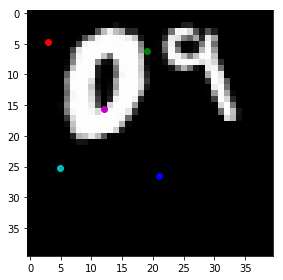

In [16]:
# plt.imshow(shuffled_imgs[example_id].reshape((input_shape[0],input_shape[1])), cmap="Greys_r")
plt.imshow(combined_images[example_id].reshape((input_shape[0],input_shape[1])), cmap="Greys_r")

plt.scatter(a_ul[0], a_ul[1], color='r')
plt.scatter(a_ur[0], a_ur[1], color='g')
plt.scatter(a_br[0], a_br[1], color='b')
plt.scatter(a_bl[0], a_bl[1], color='c')
plt.scatter(a_center[0], a_center[1], color='m')
# plt.xticks([])
# plt.yticks([])
# plt.ylim((0,40))
plt.tight_layout()
plt.show()

In [17]:
# GradCAM and GuidedGradCAM requires a specific layer
target_layer = "max_pooling2d_3" # VGG only

In [18]:
# Optional
test_images = np.copy(combined_images[:10])
predictions = model.predict(test_images)

In [19]:
# for i, p in enumerate(predictions):
#     if np.max(p) < 1. :
#         print(i, np.max(p))

In [37]:
# Which class you want to target.
target_class = 9

pred_id = np.argmax(predictions[example_id])
print("probability:", predictions[example_id][target_class])
print("prediction id:", pred_id)
print("target id:", target_class)

probability: 0.7901656
prediction id: 9
target id: 9


# GradCAM

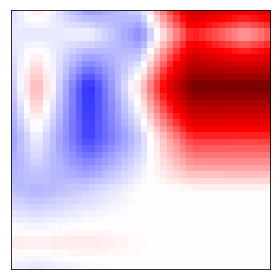

In [38]:
partial_gradcam_analyzer = GradCAM(
    model=partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=False,
)
analysis_partial_grad_cam = partial_gradcam_analyzer.analyze(test_images)
heatmap(analysis_partial_grad_cam[example_id].sum(axis=(2)))
plt.show()

# Guided Back Propagation

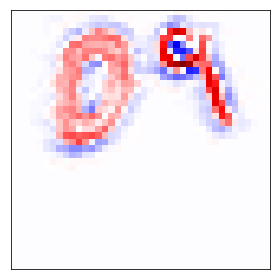

In [39]:
guidedbackprop_analyzer = GBP(
    partial_model,
    target_id=target_class,
    relu=False,
)
analysis_guidedbackprop = guidedbackprop_analyzer.analyze(test_images)
heatmap(analysis_guidedbackprop[example_id].sum(axis=(2)))
plt.show()

# GuidedGradCAM

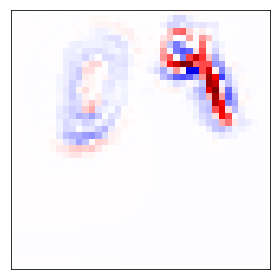

In [40]:
guidedgradcam_analyzer = GuidedGradCAM(
    partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=False,
)
analysis_guidedgradcam = guidedgradcam_analyzer.analyze(test_images)
heatmap(analysis_guidedgradcam[example_id].sum(axis=(2)))
plt.show()

# LRP

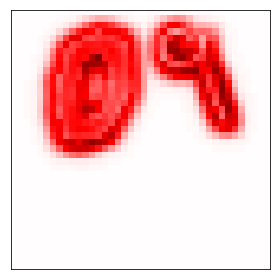

In [41]:
lrp_analyzer = LRP(
    partial_model,
    target_id=target_class,
    relu=False,
    low=min_input,
    high=max_input,
)
analysis_lrp = lrp_analyzer.analyze(test_images)
heatmap(analysis_lrp[example_id].sum(axis=(2)))
plt.show()

# CLRP

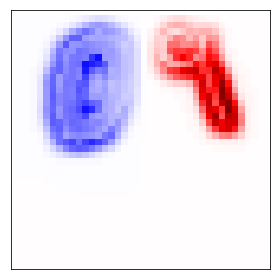

In [42]:
clrp_analyzer = CLRP(
    partial_model,
    target_id=target_class,
    relu=False,
    low=min_input,
    high=max_input,
)
analysis_clrp = clrp_analyzer.analyze(test_images)
heatmap(analysis_clrp[example_id].sum(axis=(2)))
plt.show()

# SGLRP

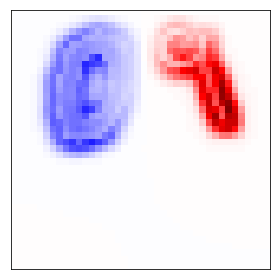

In [43]:
sglrp_analyzer = SGLRP(
    partial_model,
    target_id=target_class,
    relu=False,
    low=min_input,
    high=max_input,
)
analysis_sglrp = sglrp_analyzer.analyze(test_images)
heatmap(analysis_sglrp[example_id].sum(axis=(2)))
plt.show()

In [27]:
# oaglrp_analyzer = OAGLRP(
#     partial_model,
#     target_id=target_class,
#     relu=False,
#     scaling=False,
#     low=min_input,
#     high=max_input,
# )
# analysis_oaglrp = oaglrp_analyzer.analyze(input_imgs)
# heatmap(analysis_oaglrp[example_id].sum(axis=(2)))
# plt.show()